<a href="https://colab.research.google.com/github/caio10012/Estudo_Python/blob/main/CNN/Lenet_e_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch

Veremos agora o uso da biblioteca PyTorch pra implementar o Lenet. Hoje em dia, em torno de 80% dos trabalhos com redes neurais utilizam essa biblioteca e outros 20%, utilizam o TensorFlow. Essa biblioteca encapsula o TensorFlow, porém, dá uma boa liberdade para o desenvolvedor ajustar o modelo criado.


Na primeira parte, são importados todas as bibliotecas que iremos precisar para construir nossa primeira rede neural com o PyTorch.

In [29]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms


import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


Nessa outra parte do código, colocamos alguns parâmetros da rede neural, como taxa de aprendizado, tamanho do lote, número de épocas.

Outros parâmetros importantes são o tamanho da entrada, que é relacionado ao tamanho da matriz de entrada e o número de classes que produzirá a resposta final.

In [30]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [31]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn-v0_8')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax.legend()
    fig.show()

    # change the plot style to default
    plt.style.use('default')

##Construindo a Rede Neural


O módulo torch.nn.Module é o principal no design da arquitetura da rede neural no PyTorch. O PyTorch fornece vários tipos de camadas. Essa classe pode ser usada para implementar uma camada como uma camada totalmente conectada, uma camada convolucional, uma camada de pool, uma função de ativação e também uma rede neural inteira, instanciando um objeto torch.nn.Module.

Vários objetos nn.Module podem ser agrupados para formar um objeto nn.Module maior, que é como podemos implementar uma rede neural usando várias camadas.

A classe nn.Module possui dois métodos que você deve substituir:

*A  função __init__ - Esta função é chamada quando você cria uma instância do nn.Module. Aqui você definirá os vários parâmetros de uma camada, como filtros, tamanho do kernel para uma camada convolucional, probabilidade do dropout.

*A função forward - É aqui que você define como sua saída é calculada. Essa função não precisa ser chamada explicitamente e pode ser executada apenas chamando a instância nn.Module como uma função com a entrada como argumento.

*Outra* classe amplamente usada é a classe nn.Sequential. Ao iniciar esta classe, podemos passar uma lista de objetos nn.Module em uma sequência específica. O objeto retornado por nn.Sequential é um objeto nn.Module. Quando esse objeto é executado com uma entrada, ele executa a entrada sequencialmente em todo o objeto nn.Module que passamos para ele, na mesma ordem em que passamos por eles.

##**Lenet**


LeNet-5 é uma rede neural convolucional de 7 camadas, treinada em imagens em tons de cinza de tamanho 32 x 32 pixels.



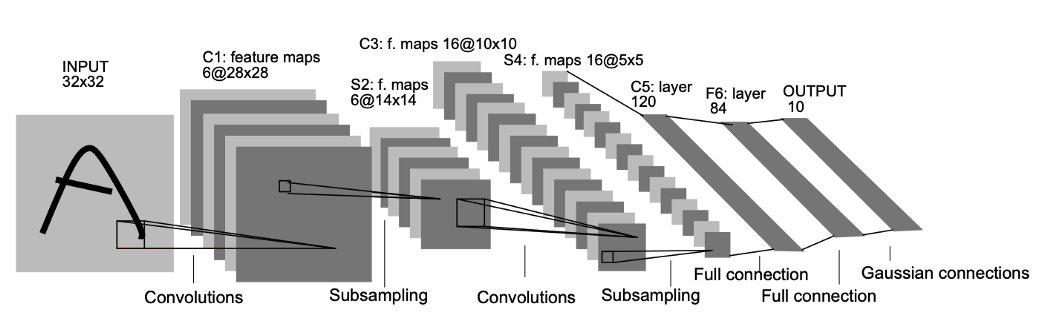

Note a mudança de dimensões em cada camada. Porque após a entrada, a camada tem dimensão 28x28x6?

**Camada 1 (C1)**: A primeira camada convolucional com 6 núcleos de tamanho 5×5.

**Camada 2 (S2)**: Uma camada de subamostragem/pooling com 6 filtros de tamanho 2×2 e stride 2.

**Camada 3 (C3)**: A segunda camada convolucional com a mesma configuração da primeira, porém, desta vez com 16 filtros.

**Camada 4 (S4)**: A segunda camada de pooling. A lógica é idêntica à anterior, mas desta vez a camada possui 16 filtros.

**Camada 5 (C5)**: A última camada convolucional com 120 filtros de tamanho 5×5. Dado que a entrada para esta camada é de tamanho 5×5×16 e os núcleos são de tamanho 5×5, a saída é de 1×1×120. Ou seja, transforma os dados pra um vetor que servirá como entrada da primeira camada totalmente conectada.

**Camada 6 (F6)**: A primeira camada totalmente conectada, que recebe a entrada de 120 atributos e retorna 84 atributos.

**Camada 7 (F7)**: A última camada densa, produz 10 atributos.

In [40]:
class LeNet5(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),  # Alterado para 3 canais
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


##*Mini-VGG*

A arquitetura da Mini-VGG é uma simplificação da arquitetura da rede VGG. Ela possui 11 camadas distribuídas em blocos de Camadas de Convolução e Normalização de Lotes, e depois Camadas Totalmente Conectadas.

-----------------------------------
Convolução com 64 filtros

Convolução com 64 filtros + Batch Normalization

Convolução com 128 filtros

Convolução com 128 filtros + Batch Normalization


Convolução com 256 filtros

Convolução com 256 filtros + Batch Normalization

Convolução com 512 filtros + Batch Normalization

Totalmente Conectada com 4096 nós

Totalmente Conectada com 128 nós

Camada de saída com função de ativação Softmax com 64 nós

---------------------------------------

In [41]:
class VGG_mini(nn.Module):
    def __init__(self, n_classes):
        super(VGG_mini, self).__init__()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)  # Alterado para 3 canais
        self.norm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.norm3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.norm4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.norm5 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.norm6 = nn.BatchNorm2d(256)

        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.norm7 = nn.BatchNorm2d(512)

        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.norm8 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512 * 4 * 4, 128)
        self.norm9 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64)
        self.norm10 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, n_classes)

    def forward(self, x):
        out = F.elu(self.norm1(self.conv1(x)))
        out = F.elu(self.norm2(self.conv2(out)))
        out = self.pool(out)

        out = F.elu(self.norm3(self.conv3(out)))
        out = F.elu(self.norm4(self.conv4(out)))
        out = self.pool(out)

        out = F.elu(self.norm5(self.conv5(out)))
        out = F.elu(self.norm6(self.conv6(out)))
        out = self.pool(out)

        out = F.elu(self.norm7(self.conv7(out)))
        out = F.elu(self.norm8(self.conv8(out)))

        out = out.view(-1, 512 * 4 * 4)

        out = F.elu(self.norm9(self.fc1(out)))
        out = F.elu(self.norm10(self.fc2(out)))
        out = self.fc3(out)
        probs = F.softmax(out, dim=1)

        return out, probs


## Define o algoritmo de treinamento.

Para cada lote de observações, realizamos as seguintes etapas:

1. Executar o passo *foward* - obtendo as previsões para o lote usando os pesos atuais.

2. Calcular o valor da função de perda

3. Executar o passo *backward*, no qual os pesos são ajustados com base na perda. Esta é a etapa de “aprendizado”.

Observe que para a fase de treinamento, o modelo está no modo de treinamento (model.train()) e também é preciso zerar os gradientes de cada lote. Além disso, é calculada taxa de erro da etapa de treinamento.

In [34]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

A função de validação é muito semelhante à de treinamento, com a diferença de que não existe a etapa de aprendizagem propriamente dita (*barckward*). Observe que precisamos especificar que estamos usando o modelo apenas para avaliação - model.eval(). Não precisamos nos preocupar com os gradientes.

In [35]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss

Por último, combinamos todos eles no ciclo de treinamento:

No loop de treinamento, para cada época, executa as funções treinar e validar, com a última executando torch.no_grad() para não atualizar os pesos e economizar algum tempo de computação. Além da função de perda usada para treinamento, calculamos a precisão do modelo para as etapas de treinamento e validação usando a função get_accuracy.



In [36]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

Tendo definido as funções auxiliares, é hora de preparar os dados. Graças à popularidade do conjunto de dados MNIST (se você não estiver familiarizado com ele, você pode ler algumas informações básicas aqui), ele está prontamente disponível como um dos conjuntos de dados do torchvision.

In [37]:
# define transforms
transforms_ = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms_,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms_)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

No código acima, primeiro é definido um conjunto de transformações a serem aplicadas às imagens de origem. Primeiro redimensionamos as imagens para 32 × 32 (o tamanho de entrada do LeNet-5) e depois as convertemos em tensores. A função transforms.ToTensor() dimensiona automaticamente as imagens para o intervalo [0, 1].

A segunda etapa é definir os conjuntos de dados. Para o objeto de treinamento, especificamos download=True para fazer o download do conjunto de dados. Ao definir os conjuntos de dados, também indicamos as transformações definidas anteriormente e se o objeto específico será usado para treinamento ou não.

Por último, instanciamos os DataLoaders fornecendo o conjunto de dados, o tamanho do lote e o desejo de embaralhar o conjunto de dados em cada época. Para validação, isso não faz diferença, então definimos como False.

A função de custo de treinamento se estabiliza, enquanto a de validação às vezes exibe pequenos solavancos (valores aumentados).

Para avaliar as previsões de nosso modelo, podemos executar o código a seguir, que exibe um conjunto de números provenientes do conjunto de validação, junto com o rótulo previsto e a probabilidade que a rede atribui a esse rótulo (em outras palavras, quão confiável é a rede está na previsão).

20:01:19 --- Epoch: 0	Train loss: 0.2444	Valid loss: 0.0871	Train accuracy: 96.98	Valid accuracy: 97.17
20:01:48 --- Epoch: 1	Train loss: 0.0791	Valid loss: 0.0578	Train accuracy: 98.35	Valid accuracy: 98.14
20:02:19 --- Epoch: 2	Train loss: 0.0546	Valid loss: 0.0436	Train accuracy: 98.84	Valid accuracy: 98.67
20:02:49 --- Epoch: 3	Train loss: 0.0435	Valid loss: 0.0377	Train accuracy: 99.08	Valid accuracy: 98.79
20:03:19 --- Epoch: 4	Train loss: 0.0335	Valid loss: 0.0406	Train accuracy: 99.06	Valid accuracy: 98.69
20:03:49 --- Epoch: 5	Train loss: 0.0277	Valid loss: 0.0416	Train accuracy: 99.29	Valid accuracy: 98.77
20:04:20 --- Epoch: 6	Train loss: 0.0235	Valid loss: 0.0398	Train accuracy: 99.40	Valid accuracy: 98.89
20:04:50 --- Epoch: 7	Train loss: 0.0209	Valid loss: 0.0354	Train accuracy: 99.45	Valid accuracy: 99.00
20:05:20 --- Epoch: 8	Train loss: 0.0172	Valid loss: 0.0334	Train accuracy: 99.62	Valid accuracy: 99.10
20:05:51 --- Epoch: 9	Train loss: 0.0159	Valid loss: 0.0424	Trai

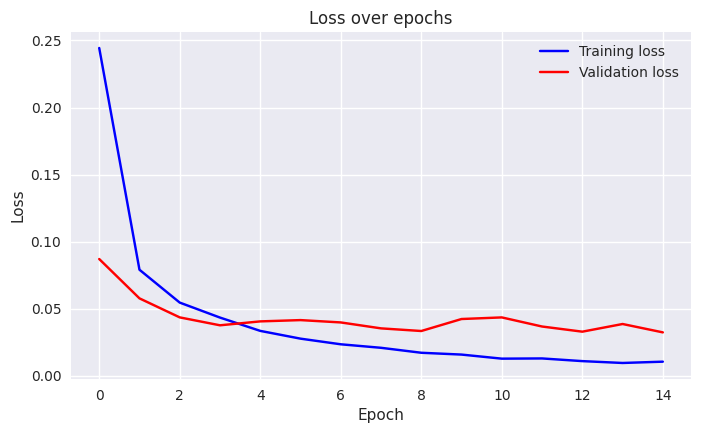

In [38]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

VGG

20:09:08 --- Epoch: 0	Train loss: 0.1046	Valid loss: 0.0549	Train accuracy: 98.08	Valid accuracy: 98.17
20:09:52 --- Epoch: 1	Train loss: 0.0503	Valid loss: 0.0257	Train accuracy: 99.21	Valid accuracy: 99.15
20:10:37 --- Epoch: 2	Train loss: 0.0405	Valid loss: 0.0292	Train accuracy: 99.17	Valid accuracy: 99.11
20:11:21 --- Epoch: 3	Train loss: 0.0339	Valid loss: 0.0313	Train accuracy: 99.22	Valid accuracy: 98.99
20:12:05 --- Epoch: 4	Train loss: 0.0292	Valid loss: 0.0211	Train accuracy: 99.56	Valid accuracy: 99.23
20:12:50 --- Epoch: 5	Train loss: 0.0249	Valid loss: 0.0214	Train accuracy: 99.51	Valid accuracy: 99.37
20:13:34 --- Epoch: 6	Train loss: 0.0217	Valid loss: 0.0217	Train accuracy: 99.68	Valid accuracy: 99.36
20:14:18 --- Epoch: 7	Train loss: 0.0197	Valid loss: 0.0252	Train accuracy: 99.60	Valid accuracy: 99.28
20:15:02 --- Epoch: 8	Train loss: 0.0167	Valid loss: 0.0222	Train accuracy: 99.67	Valid accuracy: 99.37
20:15:46 --- Epoch: 9	Train loss: 0.0157	Valid loss: 0.0149	Trai

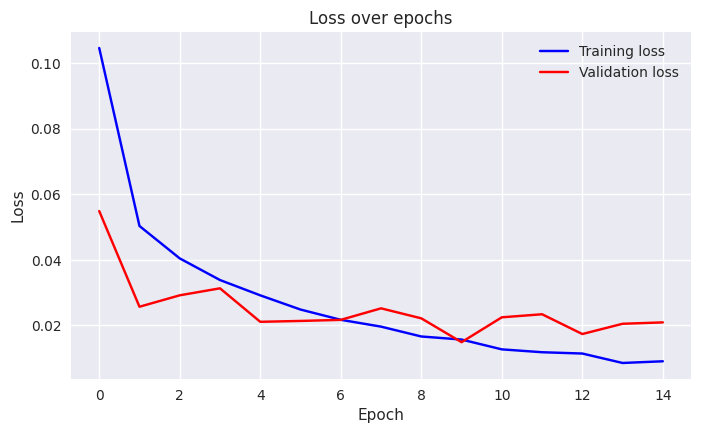

In [39]:
torch.manual_seed(RANDOM_SEED)

model = VGG_mini(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

## Exercícios

1) Utilize as redes acima na base de dados Cifar10.

In [42]:
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_cifar = datasets.CIFAR10(root='./data', train=True, transform=transforms_cifar, download=True)
train_loader_cifar = DataLoader(trainset_cifar, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset_cifar = datasets.CIFAR10(root='./data', train=False, transform=transforms_cifar, download=True)
valid_loader_cifar = DataLoader(testset_cifar, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


20:32:13 --- Epoch: 0	Train loss: 1.6418	Valid loss: 1.4310	Train accuracy: 48.21	Valid accuracy: 47.92
20:32:54 --- Epoch: 1	Train loss: 1.3841	Valid loss: 1.3415	Train accuracy: 52.92	Valid accuracy: 51.86
20:33:34 --- Epoch: 2	Train loss: 1.2730	Valid loss: 1.2393	Train accuracy: 58.63	Valid accuracy: 55.50
20:34:15 --- Epoch: 3	Train loss: 1.1928	Valid loss: 1.2083	Train accuracy: 60.66	Valid accuracy: 56.98
20:34:56 --- Epoch: 4	Train loss: 1.1272	Valid loss: 1.1947	Train accuracy: 62.44	Valid accuracy: 57.48
20:35:37 --- Epoch: 5	Train loss: 1.0725	Valid loss: 1.1620	Train accuracy: 64.62	Valid accuracy: 58.15
20:36:19 --- Epoch: 6	Train loss: 1.0237	Valid loss: 1.1778	Train accuracy: 65.38	Valid accuracy: 58.87
20:36:59 --- Epoch: 7	Train loss: 0.9844	Valid loss: 1.1231	Train accuracy: 68.06	Valid accuracy: 60.38
20:37:40 --- Epoch: 8	Train loss: 0.9436	Valid loss: 1.1199	Train accuracy: 69.81	Valid accuracy: 61.04
20:38:21 --- Epoch: 9	Train loss: 0.9077	Valid loss: 1.1223	Trai

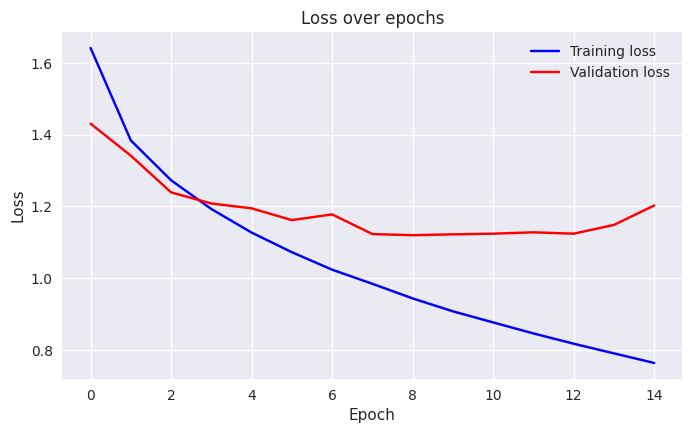

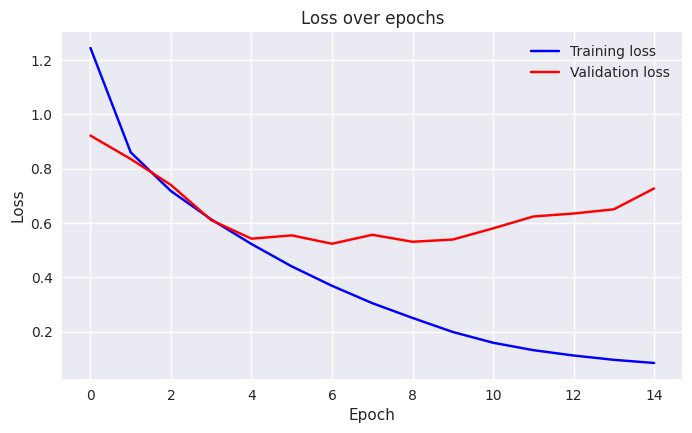

In [43]:
# LeNet5 Training with CIFAR-10
torch.manual_seed(RANDOM_SEED)
model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader_cifar, valid_loader_cifar, N_EPOCHS, DEVICE)

# VGG_mini Training with CIFAR-10
torch.manual_seed(RANDOM_SEED)
model = VGG_mini(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader_cifar, valid_loader_cifar, N_EPOCHS, DEVICE)


2) Crie sua própria rede e execute nas bases de dados MNist e Cifar10

In [50]:
class MyNetMNIST(nn.Module):
    def __init__(self, n_classes):
        super(MyNetMNIST, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * 4 * 4, out_features=512),  # Ajustado para 4096
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


20:59:03 --- Epoch: 0	Train loss: 0.1535	Valid loss: 0.0415	Train accuracy: 98.83	Valid accuracy: 98.79
20:59:36 --- Epoch: 1	Train loss: 0.0489	Valid loss: 0.0302	Train accuracy: 99.21	Valid accuracy: 98.99
21:00:08 --- Epoch: 2	Train loss: 0.0366	Valid loss: 0.0226	Train accuracy: 99.51	Valid accuracy: 99.24
21:00:41 --- Epoch: 3	Train loss: 0.0286	Valid loss: 0.0210	Train accuracy: 99.62	Valid accuracy: 99.26
21:01:14 --- Epoch: 4	Train loss: 0.0233	Valid loss: 0.0212	Train accuracy: 99.67	Valid accuracy: 99.37
21:01:46 --- Epoch: 5	Train loss: 0.0198	Valid loss: 0.0268	Train accuracy: 99.62	Valid accuracy: 99.15
21:02:18 --- Epoch: 6	Train loss: 0.0179	Valid loss: 0.0183	Train accuracy: 99.80	Valid accuracy: 99.47
21:02:51 --- Epoch: 7	Train loss: 0.0157	Valid loss: 0.0301	Train accuracy: 99.55	Valid accuracy: 99.12
21:03:22 --- Epoch: 8	Train loss: 0.0150	Valid loss: 0.0215	Train accuracy: 99.84	Valid accuracy: 99.37
21:03:55 --- Epoch: 9	Train loss: 0.0130	Valid loss: 0.0261	Trai

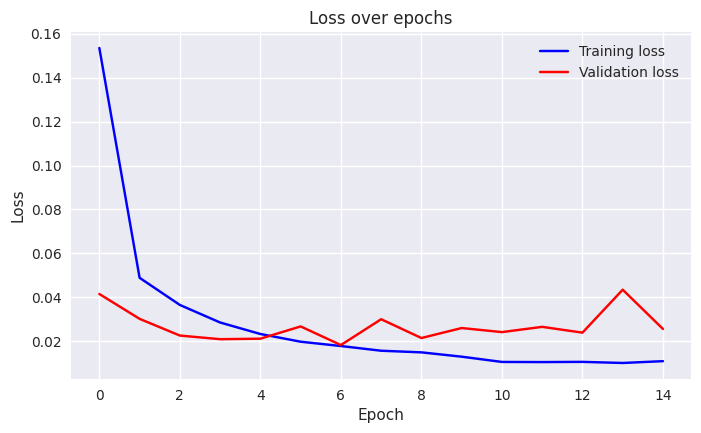

In [51]:
torch.manual_seed(RANDOM_SEED)
model_mnist = MyNetMNIST(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_mnist.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
model_mnist, optimizer, _ = training_loop(model_mnist, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)


In [52]:
class MyNet(nn.Module):
    def __init__(self, n_classes):
        super(MyNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * 4 * 4, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


21:07:30 --- Epoch: 0	Train loss: 1.3713	Valid loss: 0.9767	Train accuracy: 66.88	Valid accuracy: 64.99
21:08:12 --- Epoch: 1	Train loss: 0.9026	Valid loss: 0.8071	Train accuracy: 75.70	Valid accuracy: 71.37
21:08:55 --- Epoch: 2	Train loss: 0.7166	Valid loss: 0.6928	Train accuracy: 82.49	Valid accuracy: 76.43
21:09:38 --- Epoch: 3	Train loss: 0.6001	Valid loss: 0.7139	Train accuracy: 83.78	Valid accuracy: 75.95
21:10:21 --- Epoch: 4	Train loss: 0.5102	Valid loss: 0.6558	Train accuracy: 88.90	Valid accuracy: 77.98
21:11:03 --- Epoch: 5	Train loss: 0.4407	Valid loss: 0.6556	Train accuracy: 91.06	Valid accuracy: 78.69
21:11:45 --- Epoch: 6	Train loss: 0.3791	Valid loss: 0.7322	Train accuracy: 90.50	Valid accuracy: 77.25
21:12:28 --- Epoch: 7	Train loss: 0.3284	Valid loss: 0.7188	Train accuracy: 94.49	Valid accuracy: 79.20
21:13:12 --- Epoch: 8	Train loss: 0.2910	Valid loss: 0.7936	Train accuracy: 95.00	Valid accuracy: 78.83
21:13:53 --- Epoch: 9	Train loss: 0.2659	Valid loss: 0.8040	Trai

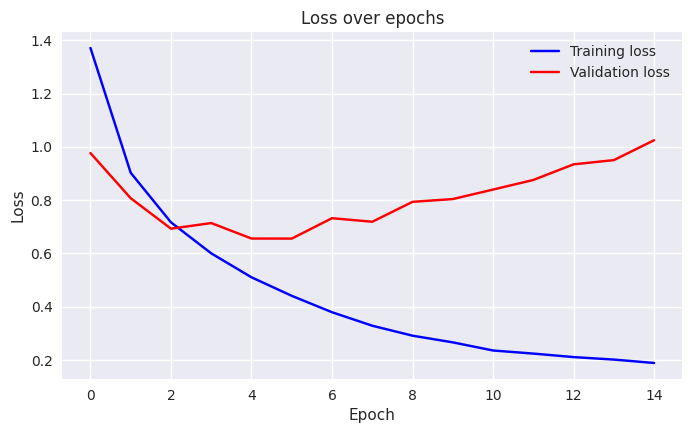

In [53]:
torch.manual_seed(RANDOM_SEED)
model_cifar = MyNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_cifar.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
model_cifar, optimizer, _ = training_loop(model_cifar, criterion, optimizer, train_loader_cifar, valid_loader_cifar, N_EPOCHS, DEVICE)
